## NLP Class Final Project
### Part 3 - Sentiment Analysis

Author: Aashish Singh

In [1]:
import os
import time
import math
import re
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from collections import Counter
import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import spacy

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import warnings

warnings.simplefilter('once')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

/Users/aashishsingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aashishsingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nl

True

In [2]:
import multiprocessing
from pandarallel import pandarallel
num_processors = multiprocessing.cpu_count()
num_processors
workers = num_processors-1
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1, use_memory_fs=False)
print(f'Using {workers} workers')

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Using 11 workers


In [3]:
%%time

news_processed = pd.read_parquet('~/Downloads/news_processed.parquet')
news_processed.shape 

CPU times: user 22.9 s, sys: 21.5 s, total: 44.5 s
Wall time: 35.4 s


(120177, 17)

In [4]:
# Sample 25% of data to run the notebook (remove during final run)
news_processed = news_processed.sample(frac=0.10, random_state=123)
news_processed.shape

(12018, 17)

In [5]:
news_processed.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count
101390,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475
58707,https://www.zmescience.com/science/news-science/chinese-communist-party-wants-to-use-an-ai-algorithm-to-read-minds-and-test-the-loyalty-of-its-members/,2022-07-20,en,"Chinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members","\n\nChinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members\n \n \nNews\n\nEnvironment\n\nHealth\n\nFuture\n\nSpace\n\nFeatures\n\nMore\n\nAbout\nThe Team\nAdvertise\nContribute\nOur stance on climate change\nPrivacy Policy\nContact\n No Result \n\n View All Result \n \n \n\n \n \n\n No Result \n\n View All Result \n \n\n\n \n\n \n\n \n\n \n\n No Result \n\n View All Result \n \n\n \n\

### 1. Sentiment Analysis - Utilize Vader

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
%%time

def sentiment_score(x):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(x)

news_sentiment = news_processed['text_cleaned'].parallel_apply(sentiment_score)
news_sentiment_df = pd.DataFrame(news_sentiment.tolist())

CPU times: user 130 ms, sys: 401 ms, total: 531 ms
Wall time: 2min 24s


In [8]:
news_sentiment_df

,neg,neu,pos,compound
0,0.070,0.629,0.301,0.9999
1,0.055,0.706,0.239,0.9992
2,0.022,0.838,0.139,0.9955
3,0.028,0.771,0.201,0.9952
4,0.040,0.823,0.137,0.9981
...,...,...,...,...
12013,0.036,0.794,0.170,0.9970
12014,0.053,0.768,0.179,0.9985
12015,0.135,0.792,0.073,-0.9739
12016,0.164,0.756,0.080,-0.9976


In [9]:
%%time

# Define a function to interpret the compound score as Positive or Negative
def label_sentiment(row):
    if row['compound'] > 0:
        return 'positive'
    elif row['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

news_sentiment_df['sentiment'] = news_sentiment_df.parallel_apply(label_sentiment, axis=1)

CPU times: user 34.1 ms, sys: 236 ms, total: 270 ms
Wall time: 323 ms


In [10]:
news_sentiment_df['sentiment'].value_counts()

sentiment
positive    11341
negative      676
neutral         1
Name: count, dtype: int64

In [11]:
news_processed = news_processed.set_index(news_sentiment_df.index)

In [12]:
news_processed['vader_sentiment'] = news_sentiment_df['sentiment']
news_processed['vader_compound'] = news_sentiment_df['compound']
news_processed['vader_positive'] = news_sentiment_df['pos']
news_processed['vader_negative'] = news_sentiment_df['neg']

In [13]:
news_processed['vader_sentiment'].value_counts()

vader_sentiment
positive    11341
negative      676
neutral         1
Name: count, dtype: int64

In [14]:
news_processed[news_processed['vader_sentiment'] == 'positive'][[
    'title_cleaned', 'text_cleaned', 'vader_sentiment', 'vader_compound', 'vader_positive'
]].sort_values(by='vader_positive', ascending=False).head(5)

,title_cleaned,text_cleaned,vader_sentiment,vader_compound,vader_positive
7503,artificial intelligence security market applications challenges growth shares trends forecast packaging news,artificial intelligence security market applications challenges growth shares trends forecast packaging news skip content thursday april us team contact us privacy policy packaging news packaging market research reports home industry report market report industry analytics market analytics market outlook market research future demands market study opportunities forecast intelligence security market applications challenges growth shares trends forecast artificial intelligence security market ...,positive,0.9999,0.417
6590,transitioning clean energy using ai could save,transitioning clean energy using ai could save transitioning clean energy using ai could save trillion years intelligent clean energy delivery projected create huge infrastructure investment savings march et source united states san francisco march globe newswire leading global digital innovation company announces release report ai save energy industry billions beyond outlines specific artificial intelligence ai tech solutions significantly reduce costs transitioning clean energy analysts vi...,positive,0.9992,0.415
6221,duet ai google workspace help holiday errands zdnet,duet ai google workspace help holiday errands zdnet trending replaced boring workouts meta quest supernatural app new favorite default email client linux took amazon free ai courses recommend spot fake data blocker windows apps keep dump useful things flipper zero apple watch buy year meta ray ban smart glasses may useful gadget tested year iphone pro review upgrade wow samsung galaxy ultra review one best smartphones year sonos era review close perfect smart speaker tried apple vision pro f...,positive,0.9999,0.400
7906,straight best friend new gay web series written ai attitude,straight best friend new gay web series written ai attitude skip main content subscribe read next news culture style life newsletter subscribe news uk world pride politics culture film tv music theatre theatre tickets scene sexuality style fashion beauty life travel home tech wellbeing business newsletter follow us tiktok privacy policy attitude uk stream publishing powered pugpig home culture culture film tv june pm straight best friend new gay web series written ai short series heartwarmin...,positive,0.9996,0.383
10739,intelligent home helper bespoke jet bot ai takes care keski,intelligent home helper bespoke jet bot ai takes care intelligent home helper bespoke jet bot ai takes care intelligent home ready move techslangthe intelligent home ready move techslang intelligent home smart home automation pro commercial intelligent home helper bespoke jet bot ai takes care intelligent home helper bespoke jet bot ai takes care intelligent home safe home secretdata info intelligent home helper bespoke jet bot ai takes care intelligent home helper bespoke jet bot ai takes c...,positive,0.9996,0.380


In [15]:
news_processed[news_processed['vader_sentiment'] == 'negative'][[
    'title_cleaned', 'text_cleaned', 'vader_sentiment', 'vader_compound', 'vader_negative'
]].sort_values(by='vader_negative', ascending=False).head(5)

,title_cleaned,text_cleaned,vader_sentiment,vader_compound,vader_negative
1782,creator ai issues war terror polygon,creator ai issues war terror polygon skip main content clock menu arrow yes mobile poly lt wire logo filed opinion creator first real post war terror movie robot rights us foreign policy austen sep edt new image century studios share story share facebook share twitter share sharing options share sharing options creator first real post war terror movie reddit pocket flipboard email austen goslin entertainment editor writes latest tv shows movies particularly loves things horror united states ...,negative,-0.9995,0.276
10382,ai bot named chaosgpt tasked destroy humanity,ai bot named chaosgpt tasked destroy humanity reportme quint novelsabout ussubscribe newsletter download appsadvertise usswitch hindihome created potrace written peter selinger created potrace written peter selinger buzz created potrace written peter selinger ai bot chaosgpt alarming tweets tasked destroy humanity new ai bot chaosgpt alarming tweets tasked destroy humanity several steps closer living black mirror episode pheliansocial buzzpublished apr istnew ai bot chaosgpt alarming tweets ...,negative,-0.9964,0.273
11453,giving ai bots control nuclear weapons could spark world war kill us,giving ai bots control nuclear weapons could spark world war kill us jump directly contentsign inirish sun us editionuk editionscottish sundream zall footballall newsirish newsworld newstech newsnewsworld newsdoomsday machine giving ai bots control nuclear weapons could spark world war kill us anthony feb feb artificial intelligence control nuclear weapons could trigger apocalyptic conflict leading expert warned ai takes greater role control devastating weaponry chances technology making mis...,negative,-0.9996,0.255
7574,terrorists could use artificial intelligence build weapons pm warns says uk lbc,terrorists could use artificial intelligence build weapons pm warns says uk lbc skip content lbc home news politics crime opinion world business radio traffic travel tech weather topics win join conversation skip navigation listen paul brand air listen join conversation news uk news london news news explained cost living war ukraine uk strikes discussing paul brand leading britain conversation listen paul brand use global player app listen live radio lbc lbc news listen terrorists could use ...,negative,-0.9995,0.254
10181,ai se mea pei le killer robot,ai se mea pei le killer robot faapasi anotusiaso lulu tesema soifuaga aifa ailoaina tekinolosi fou le malosi ai ai atamai faato militeli tala saienisi tekonolosi ai se mea pei le killer robot bymampho brescia tesema aotelega concept killer robots long subject debate speculation autonomous robots specifically designed kill humans development advanced artificial intelligence ai military technology raised concerns potential lethal autonomous weapons article delves question whether killer robots...,negative,-0.9978,0.248


In [16]:
news_processed.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,vader_sentiment,vader_compound,vader_positive,vader_negative
0,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475,positive,0.9999,0.301,0.070
1,https://www.zmescience.com/science/news-science/chinese-communist-party-wants-to-use-an-ai-algorithm-to-read-minds-and-test-the-loyalty-of-its-members/,2022-07-20,en,"Chinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members","\n\nChinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members\n \n \nNews\n\nEnvironment\n\nHealth\n\nFuture\n\nSpace\n\nFeatures\n\nMore\n\nAbout\nThe Team\nAdvertise\nContribute\nOur stance on climate change\nPrivacy Policy\nContact\n No Result \n\n View All Result \n \n \n\n \n \n\n No Result \n\n View All

In [17]:
news_processed['year_month'] = news_processed['year'].astype(str).str.zfill(2) + '-' + news_processed['month'].astype(str).str.zfill(2)

In [18]:
# Group by year and month, and calculate the average sentiment score for each month
monthly_sentiment = news_processed.groupby(['year_month'])[['vader_compound', 
                                                            'vader_positive', 
                                                            'vader_negative']].mean().reset_index()

monthly_sentiment.columns = ['year_month', 
                             'average_vader_sentiment_score',
                             'average_vader_positive_score',
                             'average_vader_negative_score']


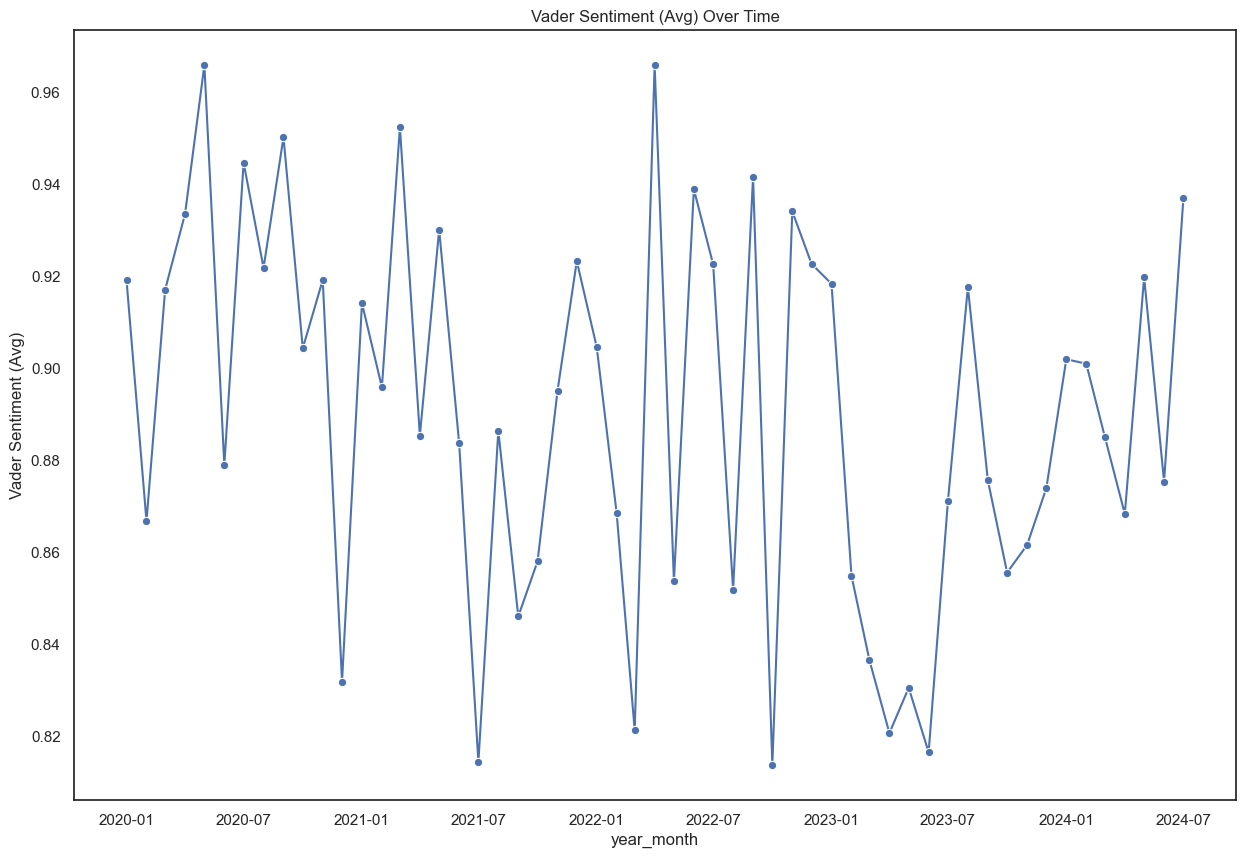

In [19]:
monthly_sentiment['year_month'] = pd.to_datetime(monthly_sentiment['year_month'])
sns.set(style="white")

plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_sentiment, x='year_month', y='average_vader_sentiment_score', marker='o')
plt.title('Vader Sentiment (Avg) Over Time', fontsize=12)
plt.ylabel('Vader Sentiment (Avg)', fontsize=12)
plt.show()

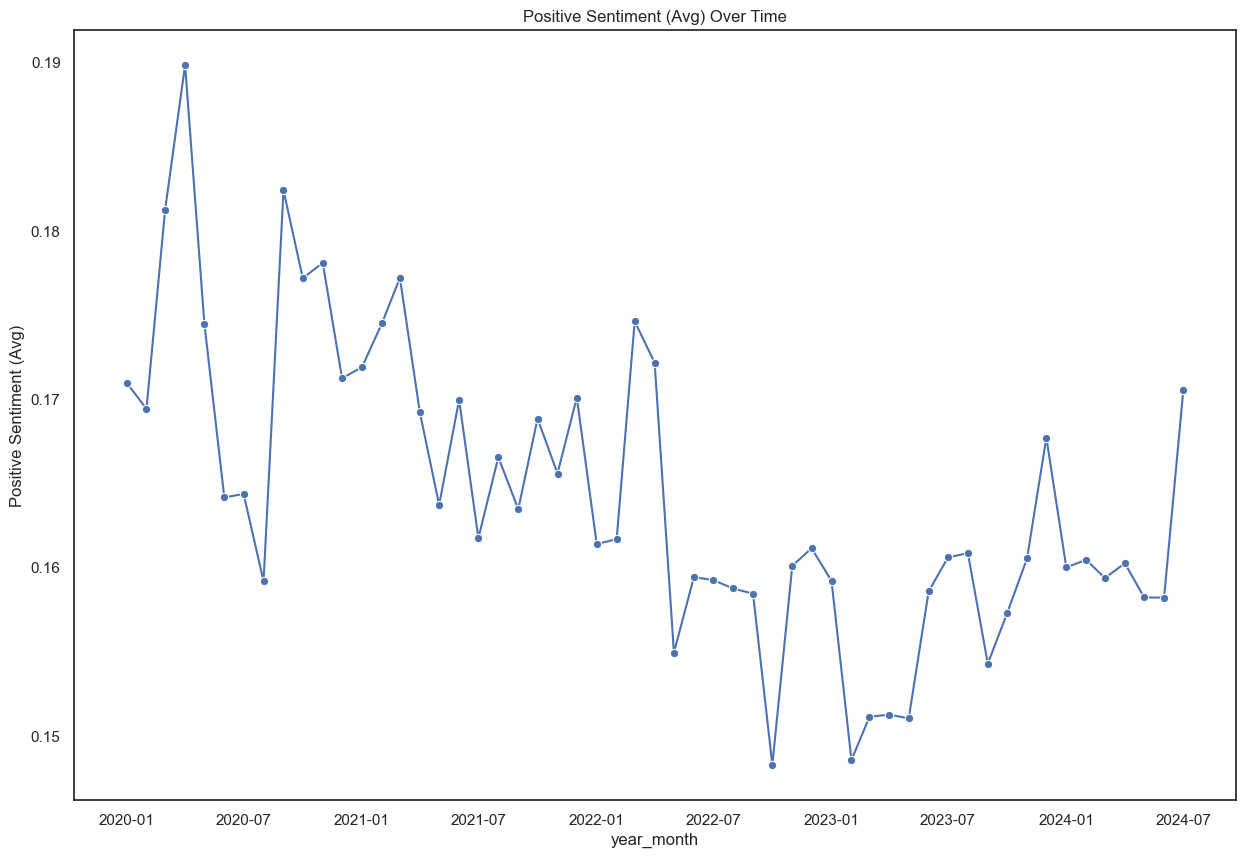

In [20]:
monthly_sentiment['year_month'] = pd.to_datetime(monthly_sentiment['year_month'])
sns.set(style="white")

plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_sentiment, x='year_month', y='average_vader_positive_score', marker='o')
plt.title('Positive Sentiment (Avg) Over Time', fontsize=12)
plt.ylabel('Positive Sentiment (Avg)', fontsize=12)
plt.show()

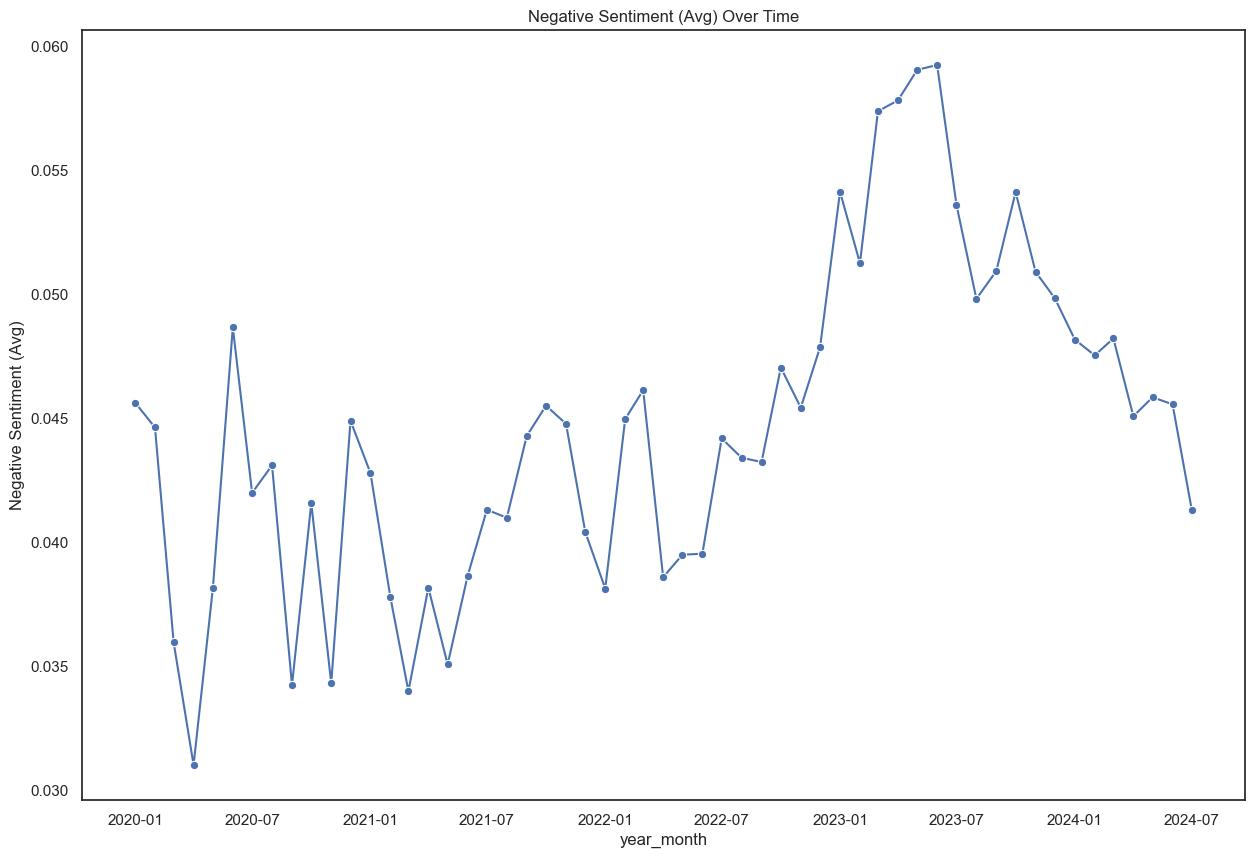

In [21]:
monthly_sentiment['year_month'] = pd.to_datetime(monthly_sentiment['year_month'])
sns.set(style="white")

plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_sentiment, x='year_month', y='average_vader_negative_score', marker='o')
plt.title('Negative Sentiment (Avg) Over Time', fontsize=12)
plt.ylabel('Negative Sentiment (Avg)', fontsize=12)
plt.show()

### 2. NER - Attach entities with sentiment

In [23]:
news_processed.head(10)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,vader_sentiment,vader_compound,vader_positive,vader_negative,year_month,title_text_lemmatized
0,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475,positive,0.9999,0.301,0.070,2023-09,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...
1,https://www.zmescience.com/science/news-science/chinese-communist-party-wants-to-use-an-ai-alg

In [30]:
def ner_spacy(col, target_lable = 'ORG', multi = -1):
    nlp = spacy.load("en_core_web_lg", exclude=['tok2vec','lemmatizer'])
    entities = []
    for doc in nlp.pipe(texts = col,  n_process=multi):
        ents = [ent.text for ent in doc.ents if ent.label_ == target_lable]
        entities.append(ents)
    return entities

In [31]:
%%time
news_processed['entity_org'] = ner_spacy(news_processed['text_lemmatized'], 'ORG', multi = -1)

CPU times: user 2min 4s, sys: 27.2 s, total: 2min 31s
Wall time: 4min 38s


In [32]:
%%time
news_processed['entity_person'] = ner_spacy(news_processed['text_lemmatized'], 'PERSON', multi = -1)

CPU times: user 1min 59s, sys: 25.2 s, total: 2min 25s
Wall time: 4min 23s


In [33]:
%%time
news_processed['entity_location'] = ner_spacy(news_processed['text_lemmatized'], 'GPE', multi = -1)

CPU times: user 2min 1s, sys: 26.5 s, total: 2min 28s
Wall time: 4min 29s


### 3. NER Entity with Setiment Word Cloud Summary

In [34]:
def wordCloud(list_col, count = 20):
    des_list = list_col.explode()
    ten = Counter(des_list).most_common(count)
    word, freq = zip(*ten)
    data = dict(zip(list(word),list(freq)))
    wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)
    return wordcloud_obj.generate_from_frequencies(data)

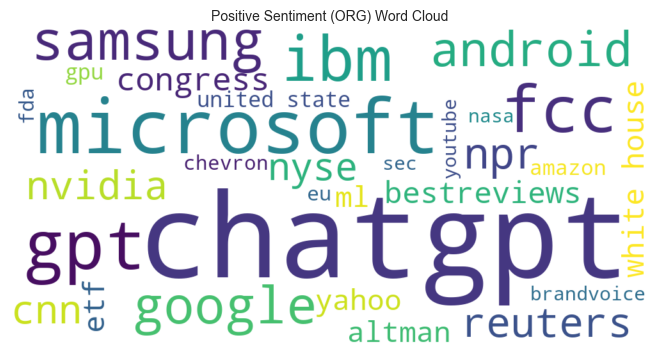

In [35]:
fig = plt.figure()
figsize = (18, 12)
plt.imshow(wordCloud(news_processed[news_processed['vader_sentiment'] == 'positive']['entity_org'], 
                     count=200), interpolation = 'bilinear')
plt.title('Positive Sentiment (ORG) Word Cloud', fontsize=10)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

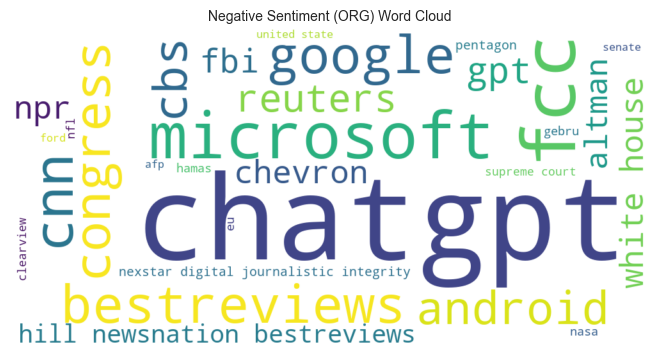

In [36]:
fig = plt.figure()
figsize = (18, 12)
plt.imshow(wordCloud(news_processed[news_processed['vader_sentiment'] == 'negative']['entity_org'], 
                     count=200), interpolation = 'bilinear')
plt.title('Negative Sentiment (ORG) Word Cloud', fontsize=10)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4. Identify top candidates for AI integration - these can be related to any industry and yield positive or negative results (sentiment analysis).
- Suggest why certain types of jobs are more likely to be impacted by AI
- Plot a timeline to illustrate how the sentiment is changing over time

#### Entity (ORG)

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner(df, col):
    # Function to count entities for a given year
    def count_entities(df, year, entity_column):
        year_df = df[df['year'] == year]
        all_entities = [entity for sublist in year_df[entity_column].dropna() for entity in sublist]
        return dict(Counter(all_entities))
    
    # Initialize a dictionary to store counts by year and entity type
    entity_counts_by_year = defaultdict(lambda: defaultdict(Counter))
    
    # Count entities for each year and entity type
    for index, row in df.iterrows():
        year = row['year']
        for entity_type in ['entity_person', 'entity_org', 'entity_location']:
            entities = row[entity_type]
            if entities:
                entity_counts_by_year[year][entity_type].update(entities)
    
    # Convert defaultdict to a regular dict for easier viewing
    entity_counts_by_year = {year: dict(types) for year, types in entity_counts_by_year.items()}
    
    # Create a DataFrame for a given year
    def create_df_for_year(year, entity_counts_by_year):
        data = [
            {'entity_type': entity_type, 'entity': entity, 'count': count}
            for entity_type, entities in entity_counts_by_year[year].items()
            for entity, count in entities.items()
        ]
        return pd.DataFrame(data)
    
    # Create separate DataFrames for each year
    news_data = {}
    for year in range(2020, 2025):  # Including 2024
        news_data[year] = create_df_for_year(year, entity_counts_by_year)
    
    # Get top 200 entities per type per year
    entity_types = ['entity_org', 'entity_person', 'entity_location']
    top_entities = {}
    for year, df_year in news_data.items():
        top_entities[year] = {
            entity_type: df_year[df_year['entity_type'] == entity_type]
            .sort_values('count', ascending=False)
            .head(200)
            .reset_index(drop=True)
            for entity_type in entity_types
        }
    
    
   # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Get counts for key entities
    def get_counts(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        counts = filtered_df.groupby('entity')['count'].sum()
        counts.name = year
        return counts
    
    # Process each year for the specified entity type
    combined_counts = pd.concat([
        get_counts(normalize_entities(pd.DataFrame(top_entities[year][col]), col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_counts = combined_counts.reset_index().rename(columns={'index': 'entity'})
    
    # Sum counts across all years
    combined_counts['total_count'] = combined_counts.iloc[:, 1:].sum(axis=1)
    
    # Sort by total count
    combined_counts_sorted = combined_counts.sort_values(by='total_count', ascending=False)
    
    # Plotting the data (combined total count for all years)
    plt.figure(figsize=(15, 10))
    sns.barplot(
        data=combined_counts_sorted, x='entity', y='total_count', palette='viridis'
    )
    
    # Enhancing the plot
    plt.title('Total Count of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Total Count')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


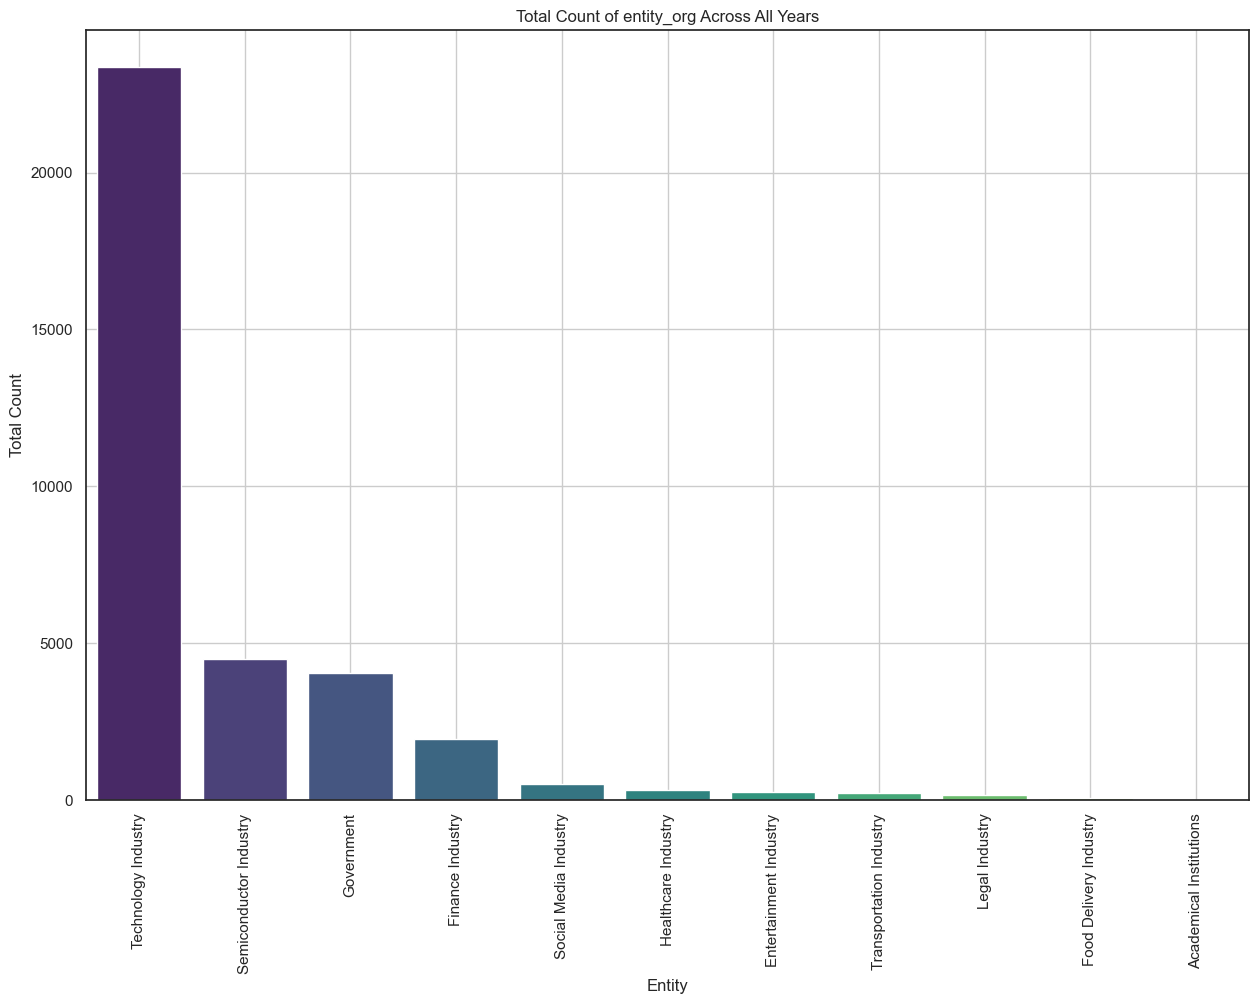

CPU times: user 1.71 s, sys: 146 ms, total: 1.86 s
Wall time: 1.74 s


In [103]:
%%time
plot_ner(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_postive(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = row['vader_positive']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Positive Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Positive Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


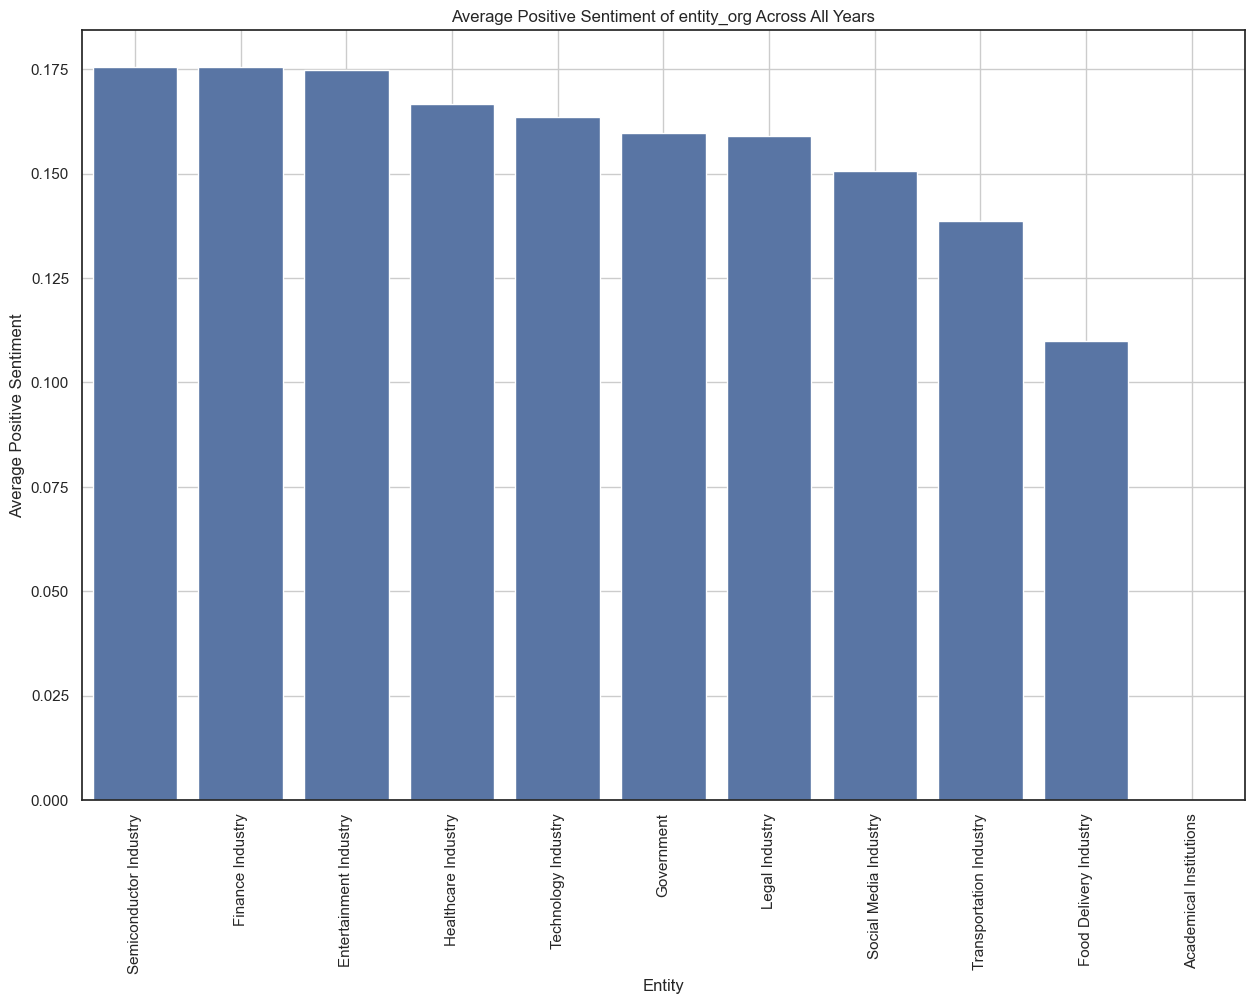

CPU times: user 2.58 s, sys: 102 ms, total: 2.68 s
Wall time: 2.51 s


In [105]:
%%time
plot_ner_postive(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_negative(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = -row['vader_negative']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Negative Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Negative Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


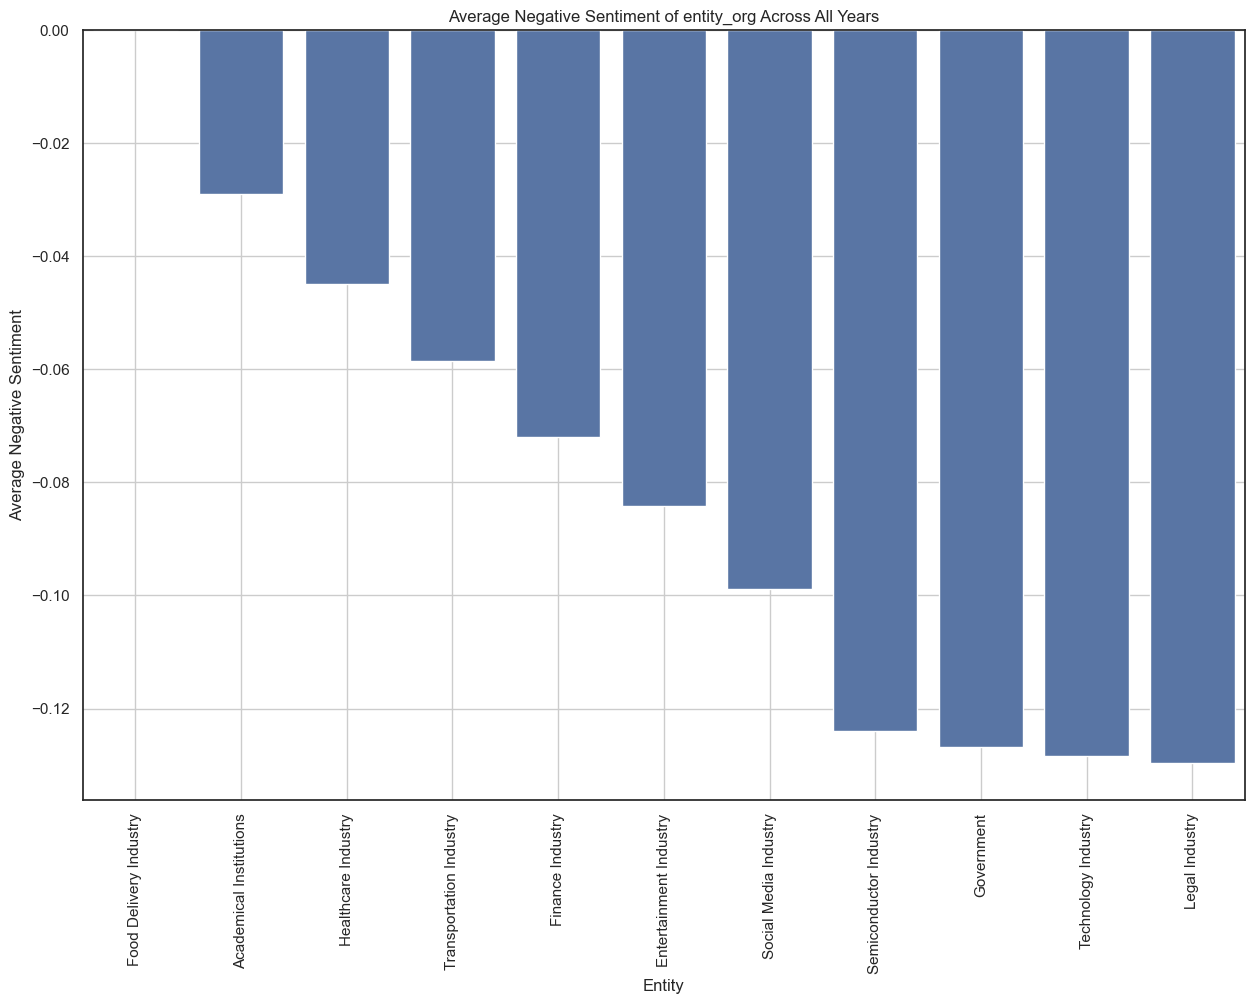

CPU times: user 530 ms, sys: 86.6 ms, total: 617 ms
Wall time: 418 ms


In [107]:
%%time
plot_ner_negative(news_processed[news_processed['vader_sentiment'] == 'negative'], 'entity_org')

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_time(df, col):
    # Function to count entities for a given year
    def count_entities(df, year, entity_column):
        year_df = df[df['year'] == year]
        all_entities = [entity for sublist in year_df[entity_column].dropna() for entity in sublist]
        return dict(Counter(all_entities))
    
    # Initialize a dictionary to store counts by year and entity type
    entity_counts_by_year = defaultdict(lambda: defaultdict(Counter))
    
    # Count entities for each year and entity type
    for index, row in df.iterrows():
        year = row['year']
        for entity_type in ['entity_person', 'entity_org', 'entity_location']:
            entities = row[entity_type]
            if entities:
                entity_counts_by_year[year][entity_type].update(entities)
    
    # Convert defaultdict to a regular dict for easier viewing
    entity_counts_by_year = {year: dict(types) for year, types in entity_counts_by_year.items()}
    
    # Create a DataFrame for a given year
    def create_df_for_year(year, entity_counts_by_year):
        data = [
            {'entity_type': entity_type, 'entity': entity, 'count': count}
            for entity_type, entities in entity_counts_by_year[year].items()
            for entity, count in entities.items()
        ]
        return pd.DataFrame(data)
    
    # Create separate DataFrames for each year
    news_data = {}
    for year in range(2020, 2025): 
        news_data[year] = create_df_for_year(year, entity_counts_by_year)
    
    # Get top 200 entities per type per year
    entity_types = ['entity_org', 'entity_person', 'entity_location']
    top_entities = {}
    for year, df_year in news_data.items():
        top_entities[year] = {
            entity_type: df_year[df_year['entity_type'] == entity_type]
            .sort_values('count', ascending=False)
            .head(200)
            .reset_index(drop=True)
            for entity_type in entity_types
        }
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Get counts for key entities
    def get_counts(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        counts = filtered_df.groupby('entity')['count'].sum()
        counts.name = year
        return counts
    
    # Process each year for the specified entity type
    combined_counts = pd.concat([
        get_counts(normalize_entities(pd.DataFrame(top_entities[year][col]), col), year, col)
        for year in range(2020, 2025)  
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_counts = combined_counts.reset_index().rename(columns={'index': 'entity'})
    
    # Melt the DataFrame for plotting
    combined_counts_melted = combined_counts.melt(
        id_vars=['entity'], var_name='year', value_name='count'
    )
    
    # Sort entities by their count in 2024
    entities_sorted_by_2024 = combined_counts.sort_values(by=2024, ascending=False)['entity']
    
    # Plotting the data
    plt.figure(figsize=(15, 10))
    sns.lineplot(
        data=combined_counts_melted, x='year', y='count', hue='entity',
        hue_order=entities_sorted_by_2024, marker='o'
    )
    
    # Enhancing the plot
    plt.title('Count of {} Over Time'.format(col))
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Entity', bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


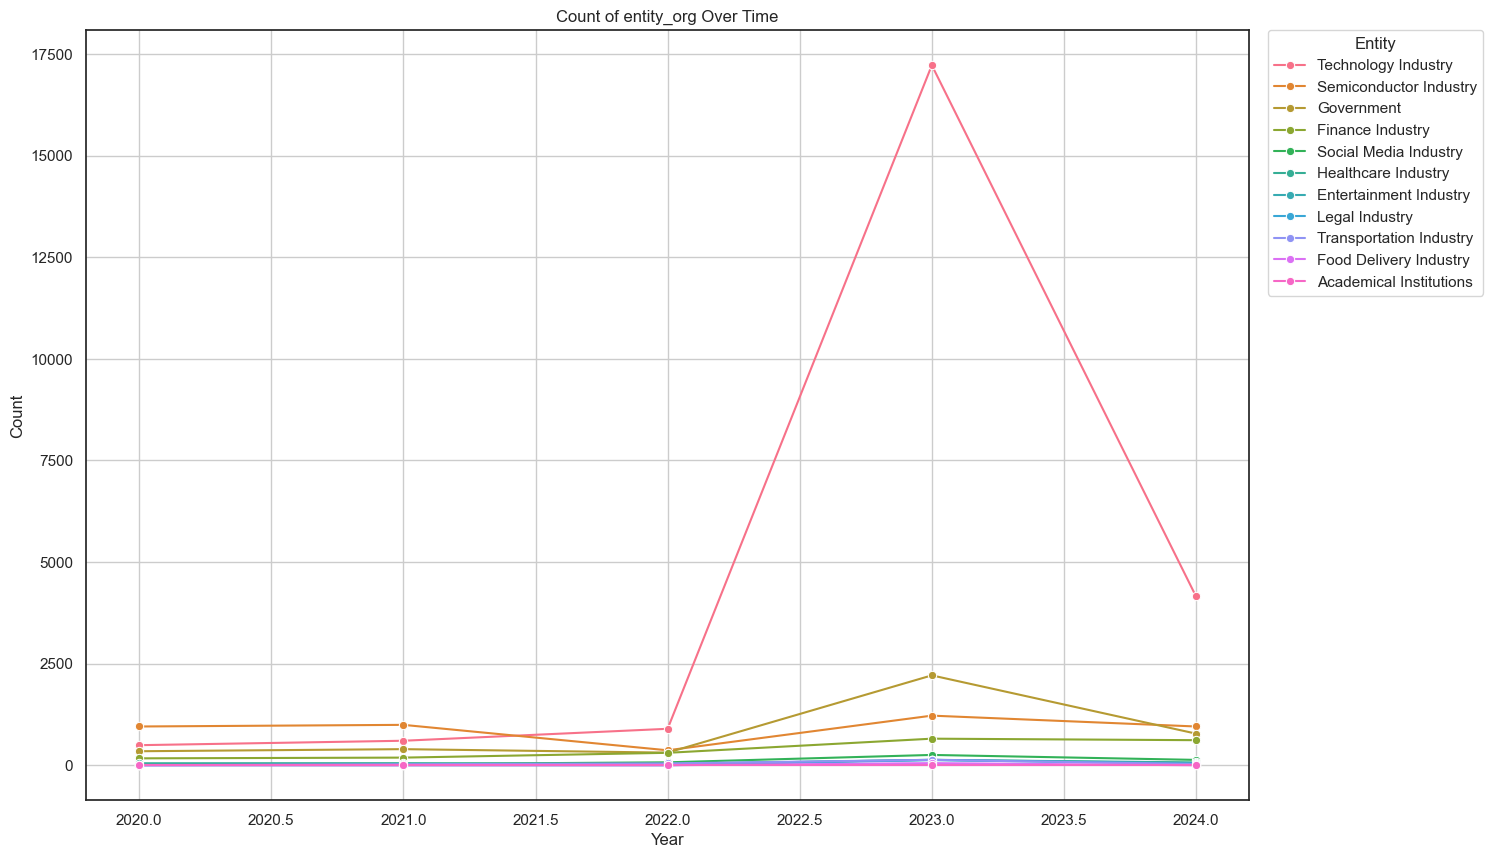

CPU times: user 1.59 s, sys: 88.8 ms, total: 1.68 s
Wall time: 1.49 s


In [109]:
%%time
plot_ner_time(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_ner_time_sentiment(df, col):
    # Function to get positive sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = row['vader_positive']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
   # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Melt the DataFrame for plotting
    combined_sentiment_melted = combined_sentiment.melt(
        id_vars=['entity'], var_name='year', value_name='sentiment'
    )
    
    # Sort entities by their sentiment in 2024
    entities_sorted_by_2024 = combined_sentiment.sort_values(by=2024, ascending=False)['entity']
    
    # Plotting the data
    plt.figure(figsize=(15, 10))
    sns.lineplot(
        data=combined_sentiment_melted, x='year', y='sentiment', hue='entity',
        hue_order=entities_sorted_by_2024, marker='o'
    )
    
    # Enhancing the plot
    plt.title('Average Positive Sentiment of {} Over Time'.format(col))
    plt.xlabel('Year')
    plt.ylabel('Average Positive Sentiment')
    plt.legend(title='Entity', bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner_sentiment(df_news, 'entity_org')  # For organizations
# plot_ner_sentiment(df_news, 'entity_person')  # For persons
# plot_ner_sentiment(df_news, 'entity_location')  # For locations


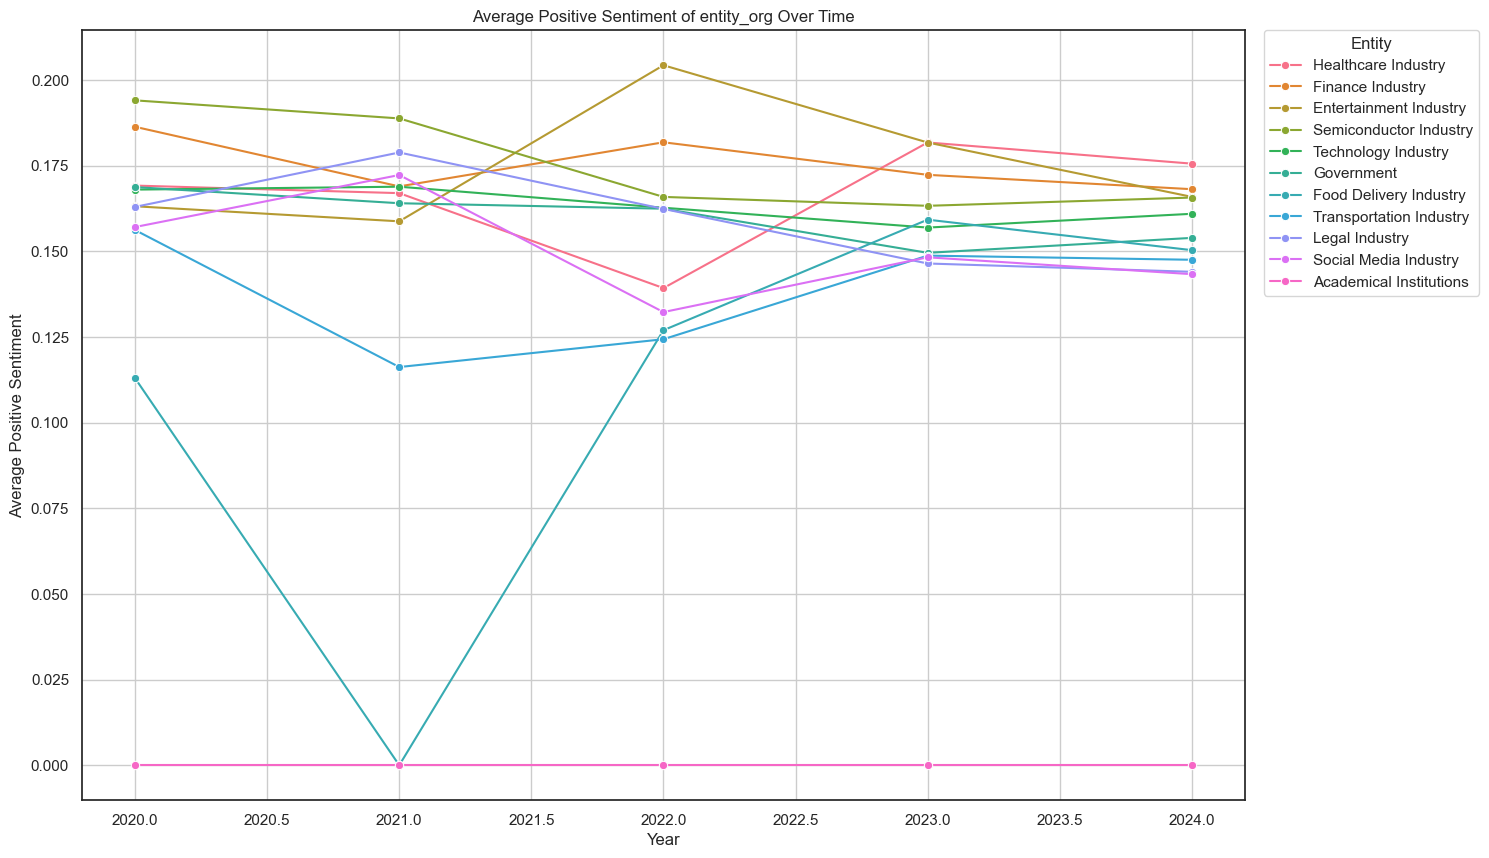

CPU times: user 2.71 s, sys: 314 ms, total: 3.03 s
Wall time: 2.83 s


In [111]:
%%time
plot_ner_time_sentiment(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

#### Entity (LOCATION)

In [116]:
news_processed[news_processed['vader_sentiment'] == 'positive'].head(20)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,vader_sentiment,vader_compound,vader_positive,vader_negative,year_month,title_text_lemmatized,entity_org,entity_person,entity_location
0,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475,positive,0.9999,0.301,0.070,2023-09,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,"[etf, hsa, fha, etf, hsa, fha, nyse, samsung, chauhan 

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner(df, col):
    # Function to count entities for a given year
    def count_entities(df, year, entity_column):
        year_df = df[df['year'] == year]
        all_entities = [entity for sublist in year_df[entity_column].dropna() for entity in sublist]
        return dict(Counter(all_entities))
    
    # Initialize a dictionary to store counts by year and entity type
    entity_counts_by_year = defaultdict(lambda: defaultdict(Counter))
    
    # Count entities for each year and entity type
    for index, row in df.iterrows():
        year = row['year']
        for entity_type in ['entity_person', 'entity_org', 'entity_location']:
            entities = row[entity_type]
            if entities:
                entity_counts_by_year[year][entity_type].update(entities)
    
    # Convert defaultdict to a regular dict for easier viewing
    entity_counts_by_year = {year: dict(types) for year, types in entity_counts_by_year.items()}
    
    # Create a DataFrame for a given year
    def create_df_for_year(year, entity_counts_by_year):
        data = [
            {'entity_type': entity_type, 'entity': entity, 'count': count}
            for entity_type, entities in entity_counts_by_year[year].items()
            for entity, count in entities.items()
        ]
        return pd.DataFrame(data)
    
    # Create separate DataFrames for each year
    news_data = {}
    for year in range(2020, 2025):  # Including 2024
        news_data[year] = create_df_for_year(year, entity_counts_by_year)
    
    # Get top 200 entities per type per year
    entity_types = ['entity_org', 'entity_person', 'entity_location']
    top_entities = {}
    for year, df_year in news_data.items():
        top_entities[year] = {
            entity_type: df_year[df_year['entity_type'] == entity_type]
            .sort_values('count', ascending=False)
            .head(200)
            .reset_index(drop=True)
            for entity_type in entity_types
        }
    
    
    # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Get counts for key entities
    def get_counts(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        counts = filtered_df.groupby('entity')['count'].sum()
        counts.name = year
        return counts
    
    # Process each year for the specified entity type
    combined_counts = pd.concat([
        get_counts(normalize_entities(pd.DataFrame(top_entities[year][col]), col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_counts = combined_counts.reset_index().rename(columns={'index': 'entity'})
    
    # Sum counts across all years
    combined_counts['total_count'] = combined_counts.iloc[:, 1:].sum(axis=1)
    
    # Sort by total count
    combined_counts_sorted = combined_counts.sort_values(by='total_count', ascending=False)
    
    # Plotting the data (combined total count for all years)
    plt.figure(figsize=(15, 10))
    sns.barplot(
        data=combined_counts_sorted, x='entity', y='total_count', palette='viridis'
    )
    
    # Enhancing the plot
    plt.title('Total Count of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Total Count')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


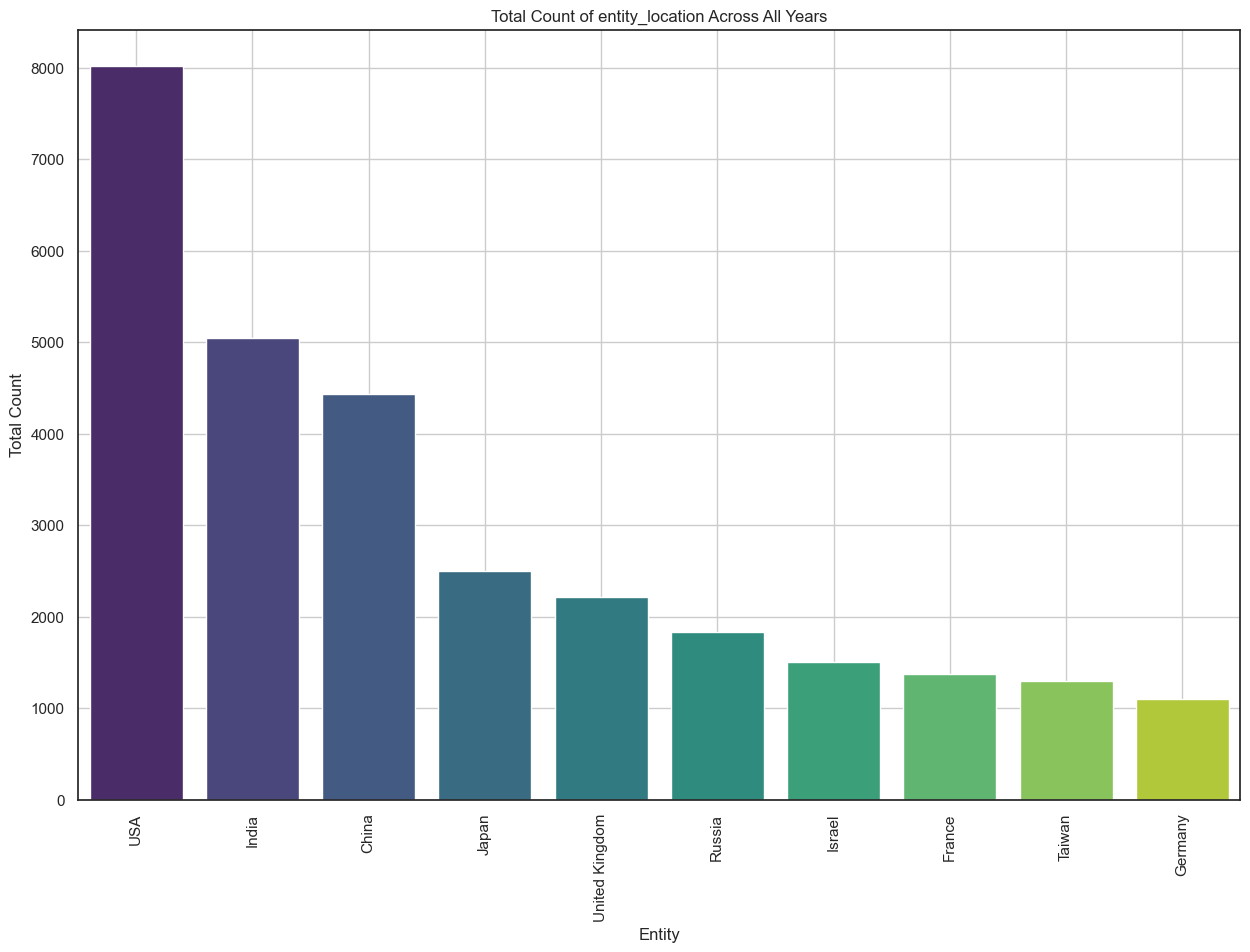

CPU times: user 1.59 s, sys: 80.4 ms, total: 1.67 s
Wall time: 1.47 s


In [124]:
%%time
plot_ner(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_location')

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_postive(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = row['vader_positive']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Positive Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Positive Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


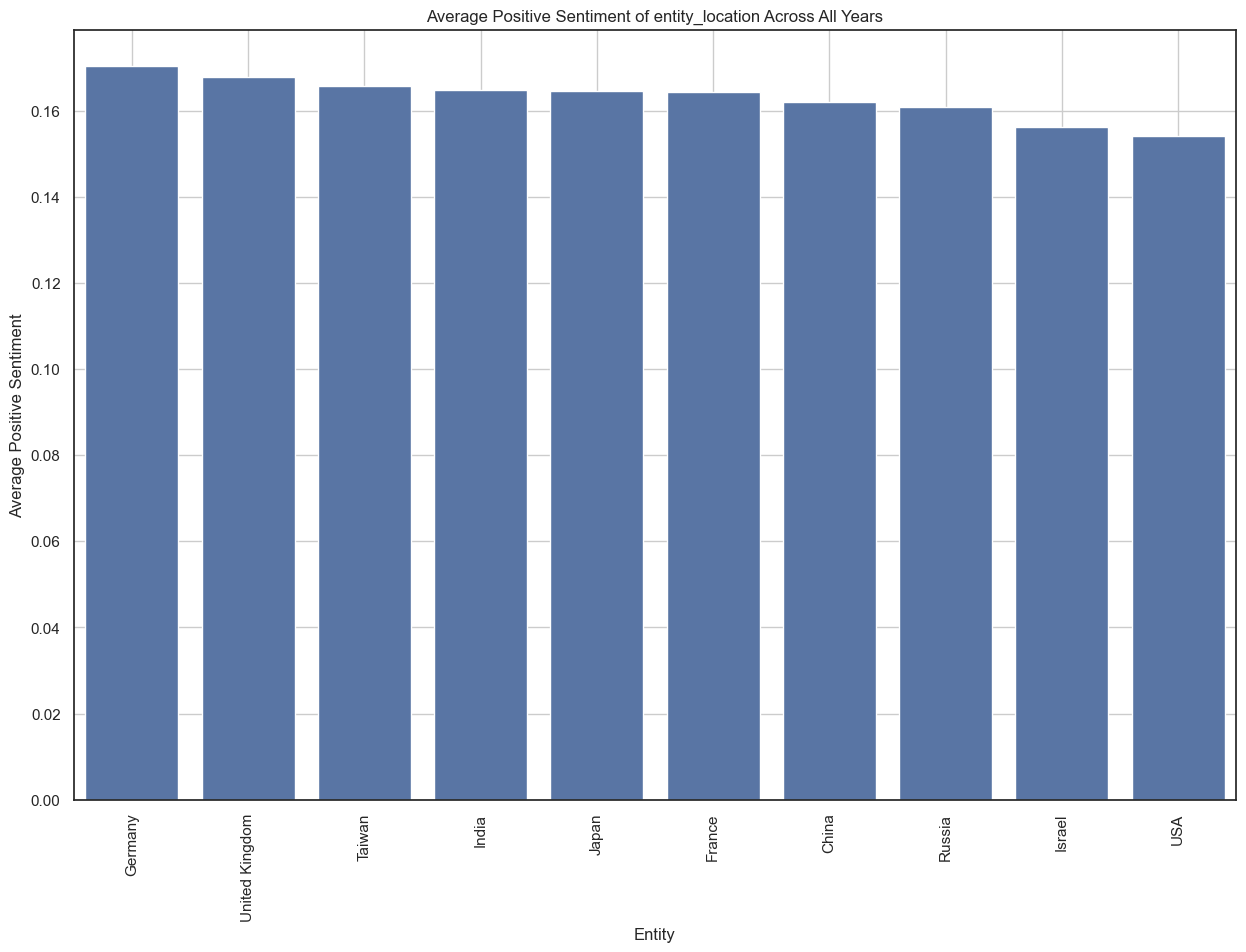

CPU times: user 1.25 s, sys: 28.3 ms, total: 1.28 s
Wall time: 1.4 s


In [126]:
%%time
plot_ner_postive(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_location')

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_negative(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = -row['vader_negative']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Negative Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Negative Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


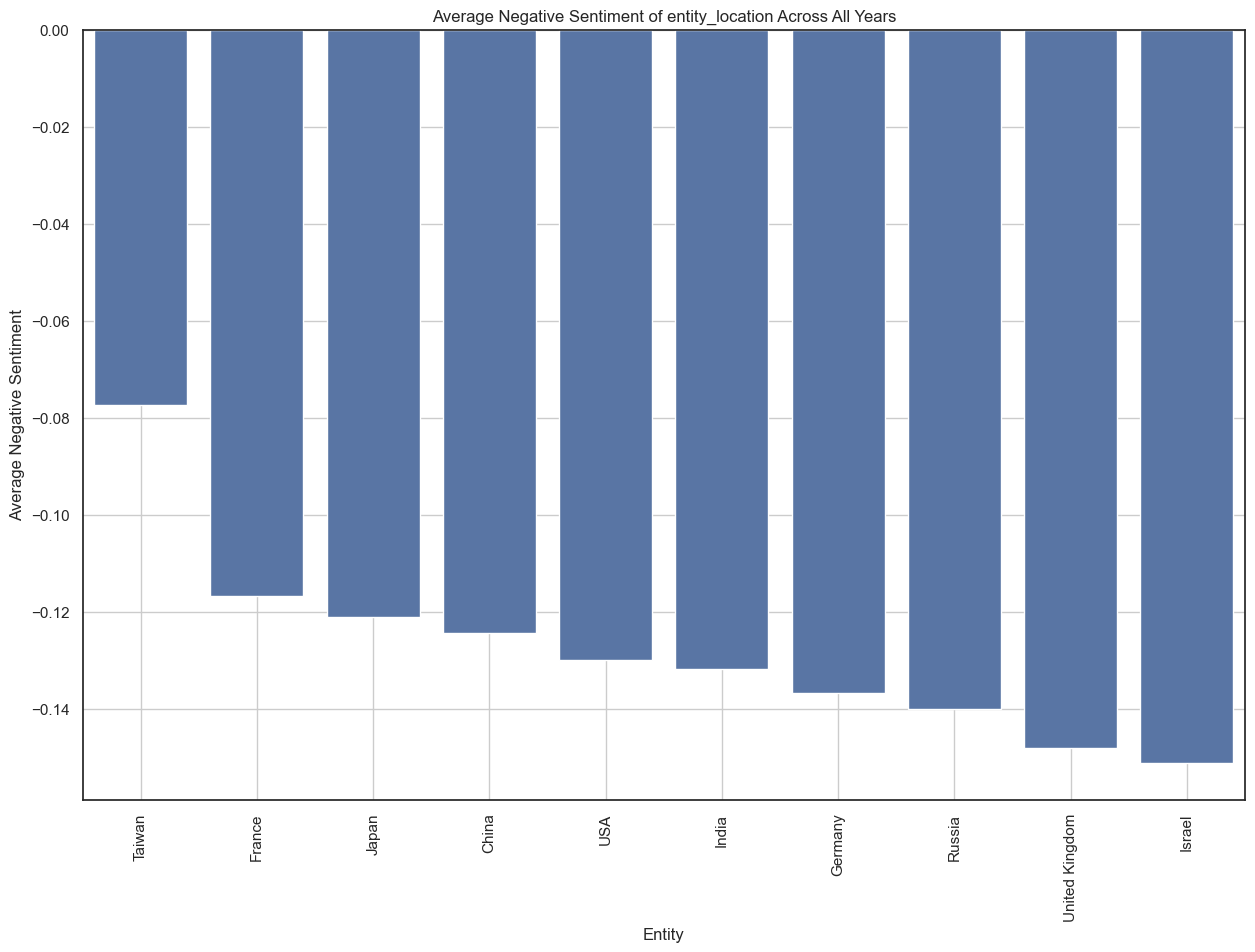

CPU times: user 452 ms, sys: 66.1 ms, total: 518 ms
Wall time: 315 ms


In [128]:
%%time
plot_ner_negative(news_processed[news_processed['vader_sentiment'] == 'negative'], 'entity_location')

In [ ]:
# news_processed.to_parquet('news_processed_with_sentiment_entity.parquet')

In [ ]:
# news_processed.to_csv('news_processed_with_sentiment_entity.csv', index=False)